## Importing the modules

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import warnings
import pickle
import time
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import seaborn as sns

/opt/homebrew/anaconda3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Loading the data

In [2]:
df = pd.read_csv('weatherDataset.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## Replacing the categorical columns

In [4]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

## Checking if data is balanced or not

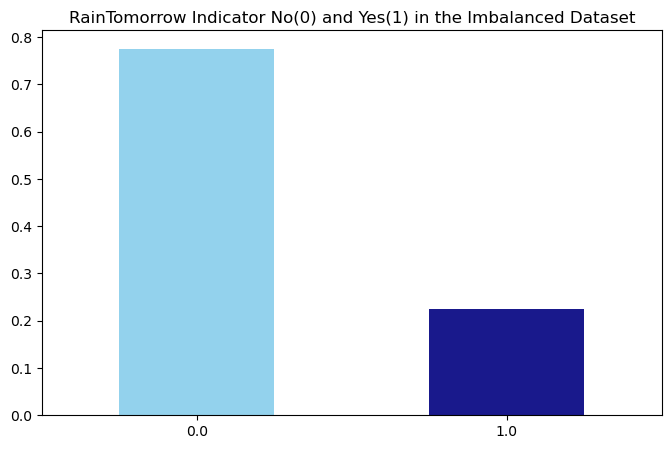

In [5]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

## Oversampling

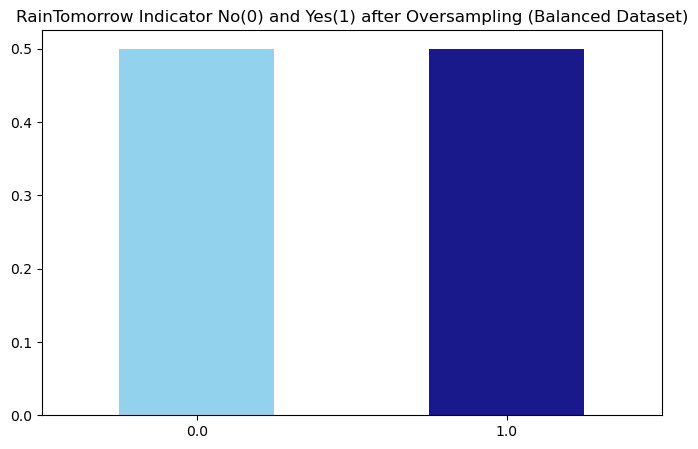

In [6]:
no = df[df['RainTomorrow'] == 0]
yes = df[df['RainTomorrow'] == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

## Handling Null Values

In [7]:
oversampled.isna().sum()

Date                  0
Location              0
MinTemp            1082
MaxTemp             471
Rainfall           3124
Evaporation       95411
Sunshine         104831
WindGustDir       15491
WindGustSpeed     15354
WindDir9am        14728
WindDir3pm         6440
WindSpeed9am       2206
WindSpeed3pm       4353
Humidity9am        3171
Humidity3pm        6031
Pressure9am       21728
Pressure3pm       21746
Cloud9am          81339
Cloud3pm          85614
Temp9am            1653
Temp3pm            4558
RainToday          3124
RainTomorrow          0
dtype: int64

In [8]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

## Imputing categorical features with mode

In [9]:
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

## Converting categorical features to continuous features with Label Encoding

In [10]:
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [11]:
lencoders
pickle.dump(lencoders,open('encoder.pkl','wb'))

## Multiple Imputation by Chained Equation

In [12]:
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Detecting outliers with IQR

In [13]:
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


## Removing outliers from the dataset

In [14]:
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

## Data Standardization

In [15]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

## Feature Importance using Filter Method

In [16]:
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [17]:
X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


## Splitting into test and train

In [18]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [19]:
# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [20]:
#Function to plot the roc_curve
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [21]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

## Using Logistic Regression

Accuracy = 0.7952798350051561
ROC Area under Curve = 0.7895421146723749
Cohen's Kappa = 0.5823246558119864
Time taken = 1.381993055343628
              precision    recall  f1-score   support

         0.0    0.80459   0.83764   0.82078     23879
         1.0    0.78229   0.74144   0.76132     18789

    accuracy                        0.79528     42668
   macro avg    0.79344   0.78954   0.79105     42668
weighted avg    0.79477   0.79528   0.79460     42668



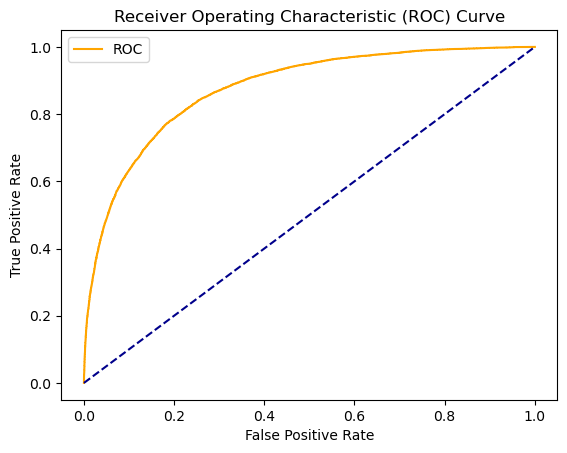

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


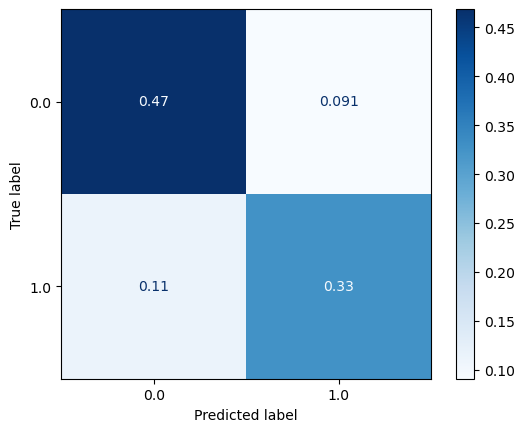

In [22]:
params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

## Decision tree

Accuracy = 0.8645354832661479
ROC Area under Curve = 0.8655635676427814
Cohen's Kappa = 0.7267901022641982
Time taken = 0.3237490653991699
              precision    recall  f1-score   support

         0.0    0.89644   0.85695   0.87625     23879
         1.0    0.82783   0.87418   0.85038     18789

    accuracy                        0.86454     42668
   macro avg    0.86213   0.86556   0.86331     42668
weighted avg    0.86623   0.86454   0.86485     42668



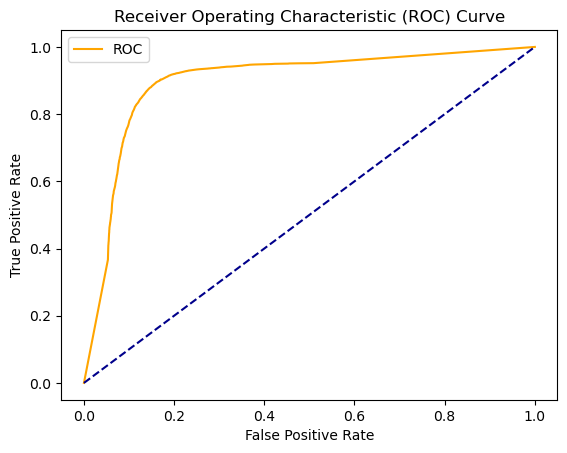

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


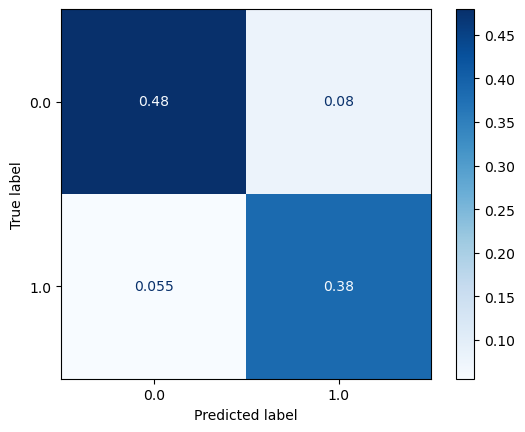

In [23]:
params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

## Random Forest

Accuracy = 0.9265960438736289
ROC Area under Curve = 0.9279584837896794
Cohen's Kappa = 0.8517906871231153
Time taken = 17.414737224578857
              precision    recall  f1-score   support

         0.0    0.95053   0.91654   0.93323     23879
         1.0    0.89854   0.93938   0.91851     18789

    accuracy                        0.92660     42668
   macro avg    0.92454   0.92796   0.92587     42668
weighted avg    0.92764   0.92660   0.92674     42668



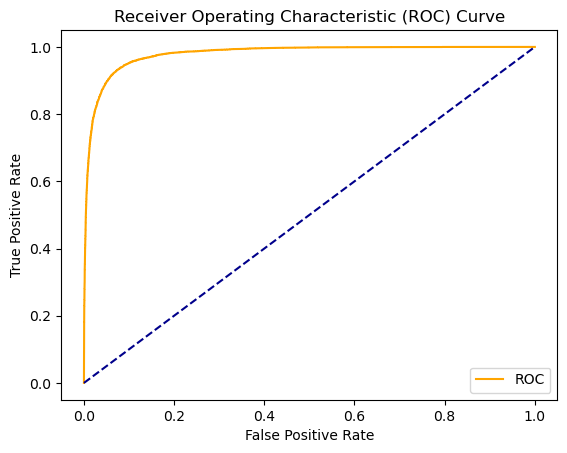

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


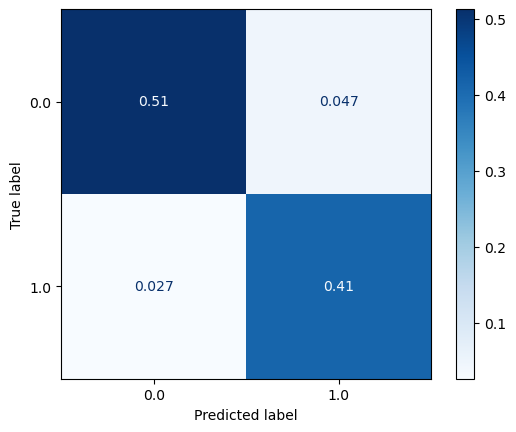

In [24]:
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

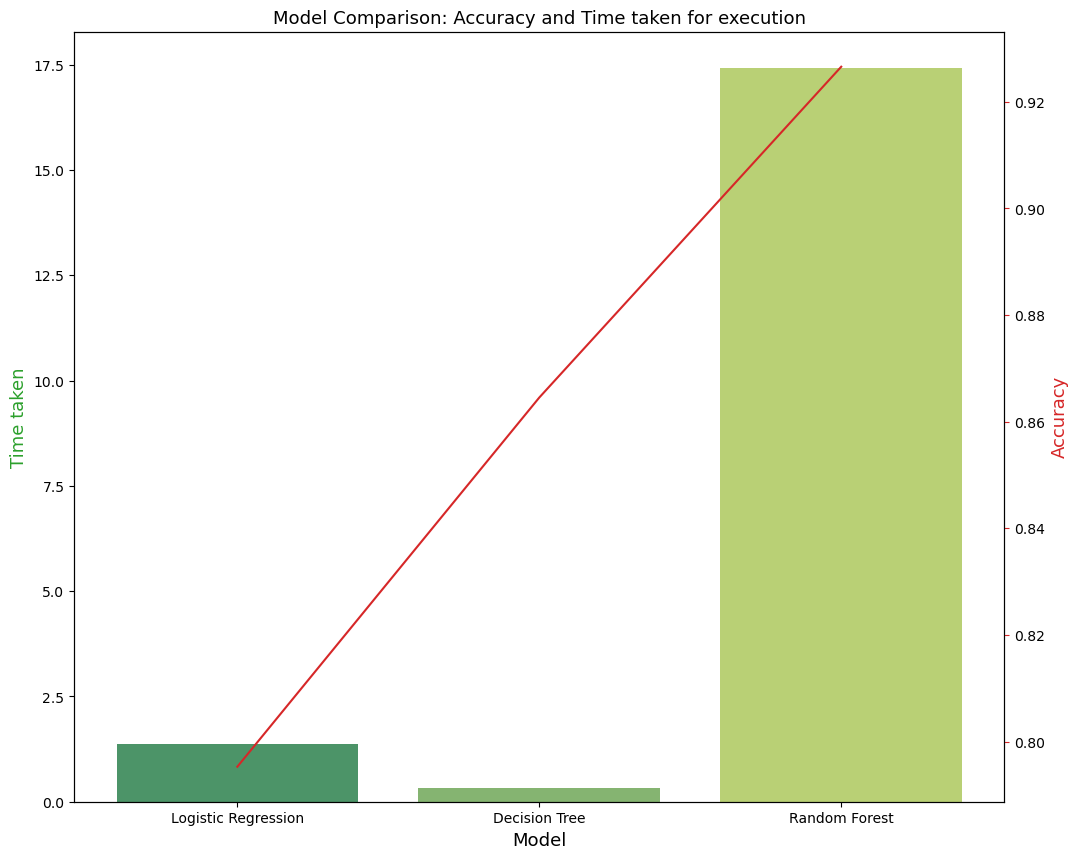

In [25]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf ]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_rf]
tt = [tt_lr, tt_dt, tt_rf]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

## Model Comparision

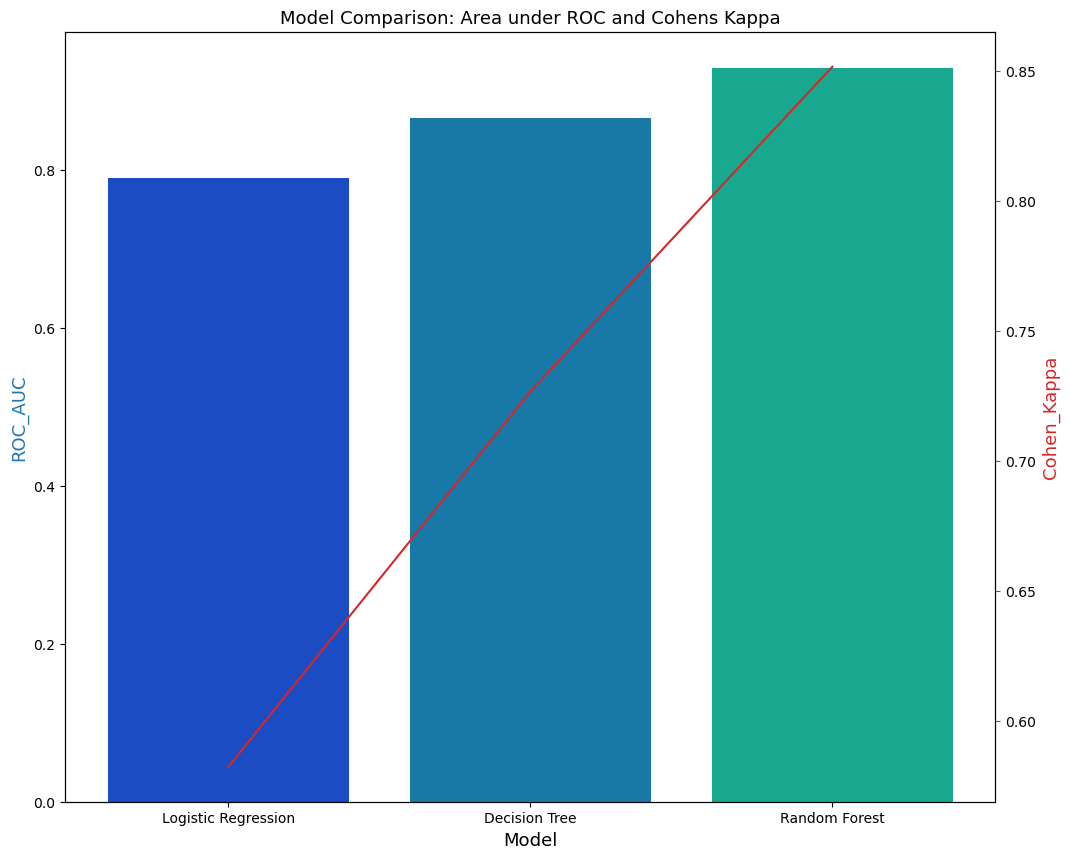

In [26]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

In [27]:
features.iloc[100]

Location            2.000000
MinTemp             8.200000
MaxTemp            24.000000
Rainfall            0.000000
Evaporation         4.348928
Sunshine           10.399552
WindGustDir        10.000000
WindGustSpeed      17.000000
WindDir9am         10.000000
WindDir3pm         10.000000
WindSpeed9am        7.000000
WindSpeed3pm       13.000000
Humidity9am        60.000000
Humidity3pm        30.000000
Pressure9am      1027.100000
Pressure3pm      1023.400000
Cloud9am            2.457706
Cloud3pm            2.489922
Temp9am            13.800000
Temp3pm            23.500000
RainToday           0.000000
Name: 128, dtype: float64

In [28]:
lencoders = pickle.load(open('encoder.pkl','rb'))
lencoders

{'Date': LabelEncoder(),
 'Location': LabelEncoder(),
 'WindGustDir': LabelEncoder(),
 'WindDir9am': LabelEncoder(),
 'WindDir3pm': LabelEncoder()}

In [29]:
features.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

In [30]:
lencoders.keys()

dict_keys(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

In [31]:
def make_prediction(scaler_path,model_path,test_data):
    scaler_custom_loaded = pickle.load(open(scaler_path,'rb'))
    model_custom_loaded = pickle.load(open(model_path,'rb'))
    x_test_data = np.array(test_data).reshape(1,-1)
    x_test_data = scaler_custom_loaded.transform(x_test_data)
    prediction = model_custom_loaded.predict(x_test_data.reshape(1,-1))[0]
    if prediction == 1:
        print('It will Rain')
    else:
        print('It wont Rain tomorrow')

In [32]:
def data_preprocessing(data):
    lst = ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday']
    for col in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
        data[col] = lencoders[col].transform([data[col]])[0]
    return data

df = df[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday']]

In [33]:
pickle.dump(features,open('data.pkl','wb'))